This tutorial demonstrates how to get started simulating an image with `cryojax`.

In [1]:
# Jax imports
import jax

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# Import the cryoJAX simulator
import cryojax.simulator as cxs

This tutorial starts by instantiating the representation of the volume. This is the protein electrostatic potential as a voxel grid in fourier space and also the pose parameterized by euler angles.

In [4]:
from cryojax.io import read_array_from_mrc


# Scattering potential stored in MRC format
filename = "./data/groel_5w0s_scattering_potential.mrc"
# ... read into a FourierVoxelGridPotential
real_voxel_grid, voxel_size = read_array_from_mrc(filename, loads_grid_spacing=True)
volume = cxs.FourierVoxelGridVolume.from_real_voxel_grid(real_voxel_grid, pad_scale=2)
# Now, instantiate the pose. Angles are given in degrees
pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=5.0,
    offset_y_in_angstroms=-3.0,
    phi_angle=20.0,
    theta_angle=80.0,
    psi_angle=-5.0,
)

To see how the electrostatic potential array is computed, see the documentation [here](https://michael-0brien.github.io/cryojax/examples/compute-potential/).

Next, instantiate the image formation parameters. This includes parameters for the instrument optics and the configuration for the image.

In [5]:
# First, the contrast transfer theory
ctf = cxs.AstigmaticCTF(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
)
transfer_theory = cxs.ContrastTransferTheory(ctf, amplitude_contrast_ratio=0.1)
# Then the configuration. Add padding with respect to the final image shape.
pad_options = dict(shape=volume.shape[0:2])
image_config = cxs.BasicImageConfig(
    shape=(80, 80),
    pixel_size=voxel_size,
    voltage_in_kilovolts=300.0,
    pad_options=pad_options,
)

Finally, instantiate the image model.

In [6]:
# Make the image model as well as a simulation function. By default, cryoJAX will simulate
# the contrast in physical units. Rather, normalize the image.
image_model = cxs.make_image_model(
    volume,
    image_config,
    pose,
    transfer_theory,
    normalizes_signal=True,
)

!!! info "What is an `image_model`?"
    These are subclasses of the abstract base class `AbstractImageModel`. CryoJAX uses `equinox` to python classes, which implements PyTorch-like syntax while maintaining smooth integration with JAX functional programming. To learn more, see [here](https://docs.kidger.site/equinox/all-of-equinox/#1-models-as-pytrees).
    
    The `make_image_model` function is just a convenience wrapper to construct an `AbstractImageModel`, the core cryoJAX class for image simulation. The important things to know about it are 1) It contains necessary parameters for
    simulating an image, such as the pose, the volume, and the CTF and 2) Images are simulated with
    `image_model.simulate()`.

    Let's print the image model to see its full structure.

In [7]:
print(image_model)

LinearImageModel(
  volume_parametrization=FourierVoxelGridVolume(
    fourier_voxel_grid=c64[160,160,160],
    frequency_slice_in_pixels=f32[1,160,160,3]
  ),
  pose=EulerAnglePose(
    offset_x_in_angstroms=f32[],
    offset_y_in_angstroms=f32[],
    offset_z_in_angstroms=None,
    phi_angle=f32[],
    theta_angle=f32[],
    psi_angle=f32[]
  ),
  volume_integrator=FourierSliceExtraction(
    outputs_integral=False,
    correction_mask=None,
    out_of_bounds_mode='fill',
    fill_value=0j
  ),
  transfer_theory=ContrastTransferTheory(
    ctf=AstigmaticCTF(
      defocus_in_angstroms=f32[],
      astigmatism_in_angstroms=f32[],
      astigmatism_angle=f32[],
      spherical_aberration_in_mm=f32[]
    ),
    envelope=None,
    amplitude_contrast_ratio=weak_f32[],
    phase_shift=f32[]
  ),
  image_config=BasicImageConfig(
    shape=(80, 80),
    pixel_size=f32[],
    voltage_in_kilovolts=f32[],
    grid_helper=None,
    pad_options={'shape': (160, 160), 'mode': 'constant', 'grid_help

Now, in JAX-style functional programming we need to define a function to simulate an image. We think about the `image_model` as a collection of arguments to pass a function for image simulation.

In [8]:
import equinox as eqx


@eqx.filter_jit
def simulate_fn(image_model):
    return image_model.simulate()

!!! info "What's with the eqx.filter_jit?"

    This is an example of a JAX transformation for JIT compilation (i.e. `jax.jit`). If you aren't familar with `jax.jit`, then start by reading the [JAX documentation](https://docs.jax.dev/en/latest/jit-compilation.html#just-in-time-compilation). In particular, `eqx.filter_jit` an `equinox` lightweight wrapper of `jax.jit` called a [*filtered transformation*](https://docs.kidger.site/equinox/all-of-equinox/#2-filtering). To learn more, including about JAX transformations for automatic diffferntiation and vectorization, see the [next cryoJAX tutorial](https://michael-0brien.github.io/cryojax/examples/jax-transformations/).

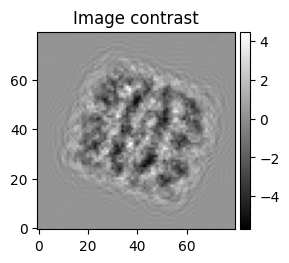

In [9]:
# Simulate the image!
fig, ax = plt.subplots(figsize=(3, 3))
im1 = plot_image(
    simulate_fn(image_model),
    fig,
    ax,
    label="Image contrast",
)
plt.tight_layout()

Alternatively, the user can simulate an image with noise from a particular statistical distribution. In this example, we use the `GaussianWhiteNoiseModel`.

Here, we will directly control image SNR through the parameters `signal_scale_factor` (a phenomenological scale factor for the underlying signal) and `variance` (the variance of the additive gaussian white noise).

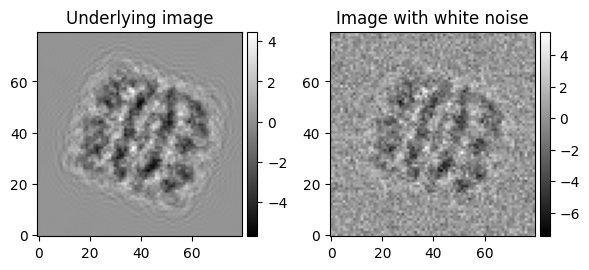

In [ ]:
import equinox as eqx
from jaxtyping import PRNGKeyArray


@eqx.filter_jit
def compute_image(noise_model: cxs.AbstractNoiseModel):
    """Simulate an image with noise from a `image_model`."""
    return noise_model.compute_signal()


@eqx.filter_jit
def compute_noisy_image(key: PRNGKeyArray, noise_model: cxs.AbstractNoiseModel):
    """Simulate an image with noise from a `image_model`."""
    return noise_model.sample(key)


# Passing the ImagePipeline and a variance function, instantiate the `noise_model``
noise_model = cxs.GaussianWhiteNoiseModel(
    image_model,
    signal_scale_factor=1.0,
    variance=1.0,
)
# ... then, either simulate an image from this `noise_model``
key = jax.random.key(seed=0)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3))
ax1, ax2 = axes
im1 = plot_image(
    compute_image(noise_model),
    fig,
    ax1,
    label="Underlying image",
)
im2 = plot_image(
    compute_noisy_image(key, noise_model),
    fig,
    ax2,
    label="Image with white noise",
)
plt.tight_layout()